### Restoration of experimental nanoparticles dataset from a pretrained restoration model

*The notebook presents the application of a pretrained restoration model (on simulated dataset) for the restoration of experimental nanoparticles reconstruction. The data are nanoparticles sinograms acquired between +/-60° with 2° tilt angle. We also perform the restoration for two more degraded scenarios where several more projections are removed :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

*The Model was trained for the restoration of simulated nanoparticles with similar features than the real ones. The model is applied on a 2D sinogram at a time.*

In [1]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import torch
from pathlib import Path

plt.gray()

dtype = torch.cuda.FloatTensor
DEVICE = 'cuda'

<Figure size 640x480 with 0 Axes>

#### Load the experimental data

The volume slice to be reconstructed is selected with **IDX** (between 0 and 512) and the acquisition case can be changed with the **ACQUISITION_CASE** parameter.

In [19]:
IDX = 159 
projections = imread('../../Data/Experimental/haadf_experimental_data.tif')
proj = normalize(projections[:,IDX])

sinogram = torch.from_numpy(projections[:,IDX,:]).type(dtype)

THETA = np.arange(27., 151., 2.)
IMG_SIZE = sinogram.shape[1]

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3
SELECT = {
    1: [sinogram, THETA],
    2: [sinogram[::5,:], THETA[::5]],
    3: [sinogram[15:-15,:], THETA[15:-15]],
}

degraded_sino = SELECT[ACQUISITION_CASE][0]
degraded_THETA = SELECT[ACQUISITION_CASE][1]

radon_op = Radon2D(angle=np.deg2rad(THETA), size=IMG_SIZE)
sirt_reco = radon_op.backward_sirt_ts(sinogram)
sirt_reco = normalize(sirt_reco)

#### Load and apply the trained network to the SIRT degraed reconstruction

*The network is setup with the same parameter than for the simulate data restoration and the pretrained weights from the same acquisition_case are loaded.*
*The model is then applied to th 2D sinogram of interest*

In [20]:
ud_filters, skip_filters = [32,64,128], [8,16,32]
n_scale = len(ud_filters)
model = model_unet(input_shape=1,
            down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
            down_kernels=[3]*len(ud_filters), up_kernels=[3]*len(ud_filters), skip_kernels=[1]*len(ud_filters),
            up_mode='bilinear', down_mode='stride', pad_mode='reflect'
           ).to('cuda').type(dtype)

model.load_state_dict(torch.load(f"../../Temp_out/model_trained_{ACQUISITION_CASE}.pth"))

/tmp/ipykernel_2816204/3537282608.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../../Temp_out/model_trained_{ACQUISITION_CASE}.pth"

<All keys matched successfully>

In [21]:
# Application of the pretrained model
net_input = rearrange(sirt_reco, '1 x y -> 1 1 x y')
out_model = model(net_input)

Text(0.5, 1.0, 'U-Net restoration from SIRT')

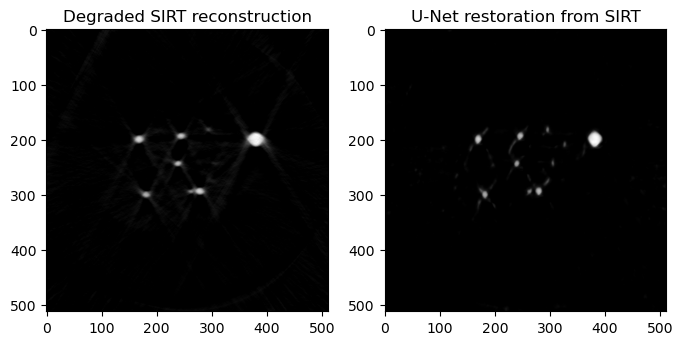

In [22]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize = (8,5))
ax0.imshow(simplify(sirt_reco))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(out_model))
ax1.set_title('U-Net restoration from SIRT')